# Simulations

Given an edge, how likely is it that I'm profitable?

In [1]:
import numpy as np
import pandas as pd
import sys

sys.path.append('..')
import calculator

In [6]:
class Market:
    '''
    Sportsbetting convience tools.
    '''
    def __init__(self, line_1=None, line_2=None):
        self.line_1 = line_1
        self.line_2 = line_2
        self.probability_1 = None
        self.probability_2 = None
        self.hold = None
        self.vig_free_1 = None 
        self.vig_free_2 = None
        
        # Calculate the hold
        self._get_market_stats()
    
    @staticmethod    
    def _get_implied_probability(line):
        '''
        Assuming American Odds
        '''
        if line >= 100:
            return 100 / (100 + line)
        else:
            return line / (-100 + line)
        
    def _get_market_stats(self):
        '''
        Get implied probabilities, the hold, and the vig free probabilities for this market.
        '''
        ## Implied Probabilities:
        self.probability_1 = self._get_implied_probability(self.line_1)
        self.probability_2 = self._get_implied_probability(self.line_2)
        
        ## Hold
        self._total_probability = self.probability_1 + self.probability_2
        self.hold = 100 * (self._total_probability - 1)
        
        ## Vig Gree
        
        self.vig_free_1 = self.probability_1 / self._total_probability
        self.vig_free_2 = self.probability_2 / self._total_probability

    @staticmethod
    def convert_american_to_decimal(line):
        if abs(line) < 100:
            raise ValueError('American Odds must be quoted like -110, +120')
        
        if line > 0:
            return (line / 100) + 1
        else:
            return (-100 / line ) + 1
        
    def calculate_edge(self, square_line):
        return round(100 * (self.convert_american_to_decimal(line=square_line) * self.vig_free_1 - 1),1)
        

In [8]:
consensus_my_side = -222
consensus_other_side = 180
soft_line = -170

consensus = Market(consensus_my_side, consensus_other_side)
consensus.calculate_edge(soft_line)

4.6

In [10]:
consensus.vig_free_1

0.658753709198813

In [21]:
Market._get_implied_probability(-170)

0.6296296296296297

In [11]:
if soft_line <= -100:
    return 

-170

In [19]:
1 / (Market.convert_american_to_decimal(-170) - 1)

1.6999999999999997

In [20]:
1 / (Market.convert_american_to_decimal(170)  - 1)

0.588235294117647

In [61]:
class OneBet:
    '''
    '''
    def __init__(self, line, estimated_roi):
        self.line = line
        self.estimated_roi = estimated_roi
        
        self.bet_size = self.get_bet_size(self)
        self.probability = self.get_estimated_probability()
    
    @staticmethod
    def get_bet_size(self):
        '''
        Number of units wagered to win one unit.
        '''
        return  1 / (Market.convert_american_to_decimal(self.line) - 1)
    
    def get_estimated_probability(self):
        '''
        If we know the line and the estimated ROI, let's back out the true probability of success.
        
        To be clear, we don't "know" this, we're just calculating this for supposition for simulations.
        '''
        
        return (self.estimated_roi + 100) / (100 * Market.convert_american_to_decimal(self.line))

0.661111111111111

In [260]:
def get_payout(bet, outcome):
    if outcome:
        payout = 1
        
    else:
        payout = -bet.bet_size
        
    return payout

In [303]:
bet = OneBet(120, 3.8)
bet.probability

trial_results = np.random.binomial(
    n=1,
    p=bet.probability,
    size=100
)

sum([get_payout(bet, outcome) for outcome in trial_results])

11.999999999999988

In [336]:
rois = np.arange(-5,6,1)
n_bets = [10, 100, 500, 1000]
n_trials = 10000

lines = [-200, -130, 130, 200]

trial_results = []

for roi in rois:
    print(roi)
    for line in lines:
        for bets in n_bets:
            bet = OneBet(line, roi)

            for trial in range(n_trials):
                outcomes = np.random.binomial(
                    n=1,
                    p=bet.probability,
                    size=bets
                )

                row = {
                    'roi': roi,
                    'n_bets': bets,
                    'line': line,
                    'PnL': sum([get_payout(bet, outcome) for outcome in outcomes]),
                    'trial': trial
                }

                trial_results.append(row)
            
        
        

-5
-4
-3
-2
-1
0
1
2
3
4
5


In [337]:
results = (
    pd.DataFrame(trial_results)
    .assign(
        profitable = lambda x: x['PnL'].transform(lambda s: 1 if s >= 0 else 0)
    )
    .groupby(['roi', 'n_bets', 'line'])
    .agg(
        profitability = ('profitable', 'mean')
    )
    .reset_index()
)

results

,roi,n_bets,line,profitability
0,-5,10,-200,0.4692
1,-5,10,-130,0.4712
2,-5,10,130,0.4069
3,-5,10,200,0.4034
4,-5,100,-200,0.2509
...,...,...,...,...
171,5,500,200,0.7868
172,5,1000,-200,0.9902
173,5,1000,-130,0.9638
174,5,1000,130,0.9227


In [338]:
import seaborn as sns

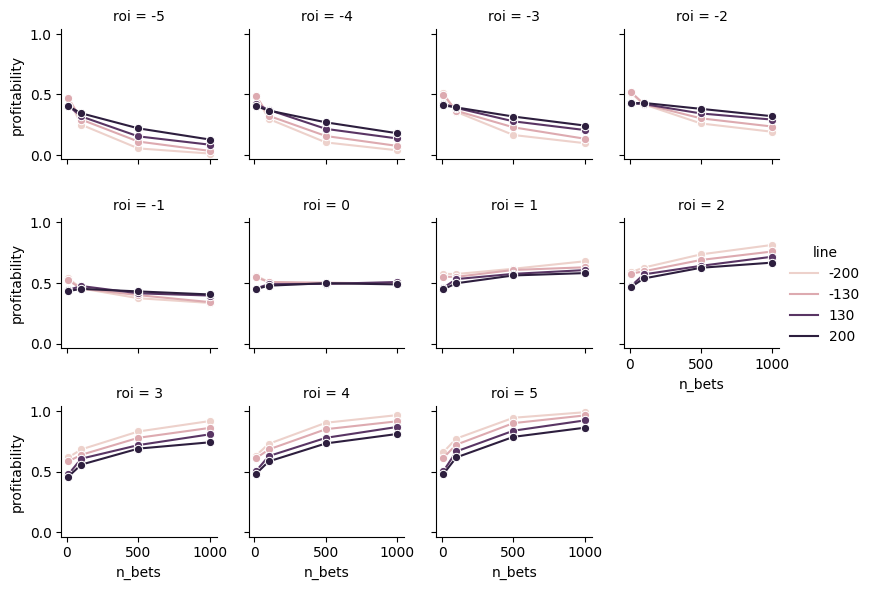

In [339]:
sns.relplot(
    data=results,
    x='n_bets',
    y='profitability',
    hue='line',
    col='roi',
    kind='line',
    marker='o',
    col_wrap=4,
    height=2
)

You have less variance with favorites. I wonder if the lines over-charge for that.

In [343]:
(
    results
    .query('roi in [-4,4]')
    .query('n_bets==1000')
    .sort_values(
        by=['n_bets', 'line', 'profitability']
    )
)

,roi,n_bets,line,profitability
28,-4,1000,-200,0.0392
156,4,1000,-200,0.9664
29,-4,1000,-130,0.0755
157,4,1000,-130,0.9155
30,-4,1000,130,0.1369
158,4,1000,130,0.8689
31,-4,1000,200,0.1802
159,4,1000,200,0.8107


- If you bet +200 odds with a 4% ROI, you'll be profitable in 81% of 1000-bet simulations.
- If you bet -200 odds with a 4% ROI, you'll be profitable in 97% of 1000-bet simulations.